In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns

In [2]:
df = pd.read_csv("seizure_pred_model_scores - LinReg.csv")

In [3]:
df.head()

,PATIENT,AGE,SEX,ONSETS,PI_SEG,PI_SEQ,PIL,AF,AUC
0,SNUCH01,9,M,2,2,2780,5,signum,0.6016
1,SNUCH02,7,M,21,6,2208,5,signum,0.5926
2,SNUCH03,11,M,5,5,2580,5,signum,0.8515
3,SNUCH04,10,M,2,2,2730,5,signum,0.8386
4,SNUCH05,4,M,1,1,2770,5,signum,0.9863


In [4]:
df = df.drop(['PATIENT'], axis=1)

In [5]:
# Label encode SEX
from sklearn.preprocessing import LabelEncoder

df['SEX_label'] = LabelEncoder().fit_transform(df.SEX)
df.head()

,AGE,SEX,ONSETS,PI_SEG,PI_SEQ,PIL,AF,AUC,SEX_label
0,9,M,2,2,2780,5,signum,0.6016,1
1,7,M,21,6,2208,5,signum,0.5926,1
2,11,M,5,5,2580,5,signum,0.8515,1
3,10,M,2,2,2730,5,signum,0.8386,1
4,4,M,1,1,2770,5,signum,0.9863,1


In [6]:
# Ordinal encode AF (in order of AUC on af_comp sheet)

enc_dict = {'signum':0,
            'elu':1,
            'selu':2,
            'relu':3,
           }

# Create the mapped values in a new column
df['AF_ordinal'] = df['AF'].map(enc_dict)
df

,AGE,SEX,ONSETS,PI_SEG,PI_SEQ,PIL,AF,AUC,SEX_label,AF_ordinal
0,9,M,2,2,2780,5,signum,0.6016,1,0
1,7,M,21,6,2208,5,signum,0.5926,1,0
2,11,M,5,5,2580,5,signum,0.8515,1,0
3,10,M,2,2,2730,5,signum,0.8386,1,0
4,4,M,1,1,2770,5,signum,0.9863,1,0
...,...,...,...,...,...,...,...,...,...,...
105,13,F,1,1,2700,5,elu,0.6255,0,1
106,11,M,4,3,2428,5,elu,0.8001,1,1
107,14,M,5,5,2100,5,elu,0.4751,1,1
108,1,M,8,7,2504,5,elu,0.5503,1,1


In [7]:
df = df.drop(['SEX', 'AF'], axis=1)

In [8]:
df.head()

,AGE,ONSETS,PI_SEG,PI_SEQ,PIL,AUC,SEX_label,AF_ordinal
0,9,2,2,2780,5,0.6016,1,0
1,7,21,6,2208,5,0.5926,1,0
2,11,5,5,2580,5,0.8515,1,0
3,10,2,2,2730,5,0.8386,1,0
4,4,1,1,2770,5,0.9863,1,0


In [9]:
# Visualization

In [10]:
X = df.drop(['AUC'], axis=1)
y = df['AUC']
labels = list(X.columns)

In [11]:
# sns.pairplot(df)

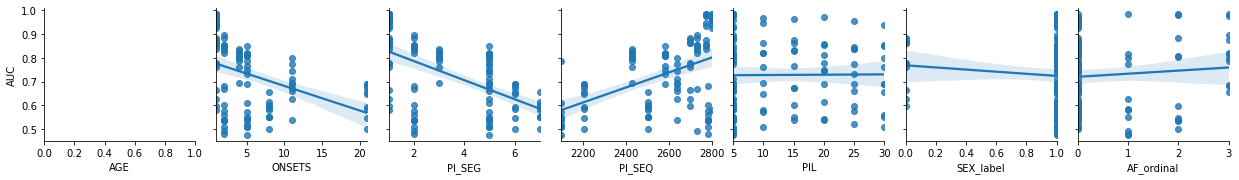

In [12]:
sns.pairplot(df, x_vars=labels, y_vars=['AUC'], kind='reg')

In [13]:
# VIF
# https://bkshin.tistory.com/entry/DATA-20-%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC-VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = labels
vif

,VIF Factor,features
0,4.829230,AGE
1,4.434372,ONSETS
2,9.110277,PI_SEG
3,18.053675,PI_SEQ
4,3.825579,PIL
5,13.561136,SEX_label
6,1.765477,AF_ordinal


In [14]:
# Drop one per pair above 10

X = X.drop(['PI_SEQ', 'ONSETS', 'SEX'], axis=1)

In [15]:
labels.remove('PI_SEQ')
labels.remove('ONSETS')

In [16]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = labels
vif

,VIF Factor,features
0,3.301185,AGE
1,4.216917,PI_SEG
2,3.337719,PIL
3,6.912615,SEX_label
4,1.636848,AF_ordinal


In [17]:
'VIF: All below 10. Good.'

'VIF: All below 10. Good.'

In [18]:
# Linear Regression
X = X.values
y = y.values.reshape(-1,1)

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [19]:
coefs = []
for i in range(len(reg.coef_[0])):
    coefs.append((labels[i], abs(round(reg.coef_[0][i],4))) )
coefs

[('AGE', 0.0076),
 ('PI_SEG', 0.0445),
 ('PIL', 0.0011),
 ('SEX_label', 0.0342),
 ('AF_ordinal', 0.018)]

In [20]:
coefs.sort(key=lambda x:x[1], reverse=True)
coefs

[('PI_SEG', 0.0445),
 ('SEX_label', 0.0342),
 ('AF_ordinal', 0.018),
 ('AGE', 0.0076),
 ('PIL', 0.0011)]

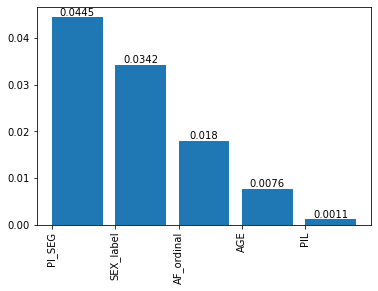

In [21]:
importance = [coef[1] for coef in coefs]
# summarize feature importance
# plot feature importance
fig, ax = plt.subplots()
p1 = ax.bar([x for x in range(len(importance))], importance, align='edge')
ax.set_xticks([x for x in range(len(importance))], labels=[coef[0] for coef in coefs], rotation='vertical')

ax.bar_label(p1, label_type='edge')

plt.show()

In [22]:
X = np.column_stack([df[col] for col in labels])
y = df['AUC']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
result = est.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    AUC   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     12.79
Date:                Mon, 02 May 2022   Prob (F-statistic):           1.08e-09
Time:                        07:44:34   Log-Likelihood:                 78.903
No. Observations:                 110   AIC:                            -145.8
Df Residuals:                     104   BIC:                            -129.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8869      0.061     14.476      0.0

In [23]:
labels

['AGE', 'PI_SEG', 'PIL', 'SEX_label', 'AF_ordinal']

In [24]:
print('Parameters: ', result.params)
r2 = round(result.rsquared, 4)
print('R2: ', r2)

Parameters:  const    0.886932
x1      -0.007610
x2      -0.044467
x3       0.001135
x4       0.034190
x5       0.018014
dtype: float64
R2:  0.3808


In [25]:
# Visualization

In [40]:
# coefficients
coefs[:4]

[('PI_SEG', 0.0445),
 ('SEX_label', 0.0342),
 ('AF_ordinal', 0.018),
 ('AGE', 0.0076)]

In [27]:
from mpl_toolkits.mplot3d import Axes3D

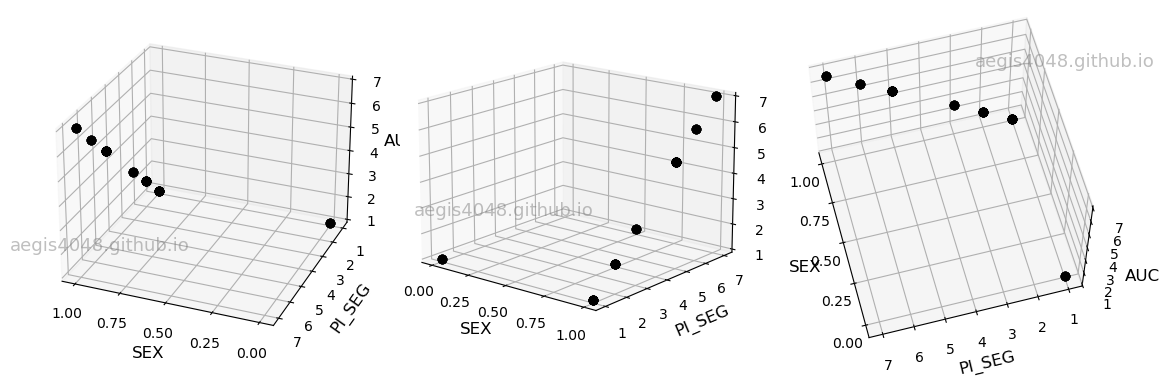

In [28]:
X = df[['SEX_label', 'PI_SEG']].values.reshape(-1,2)
y = y

x = X[:,0]
y = X[:,1]
z = y

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    #ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('SEX', fontsize=12)
    ax.set_ylabel('PI_SEG', fontsize=12)
    ax.set_zlabel('AUC', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=27, azim=112)
ax2.view_init(elev=16, azim=-51)
ax3.view_init(elev=60, azim=165)

fig.tight_layout()

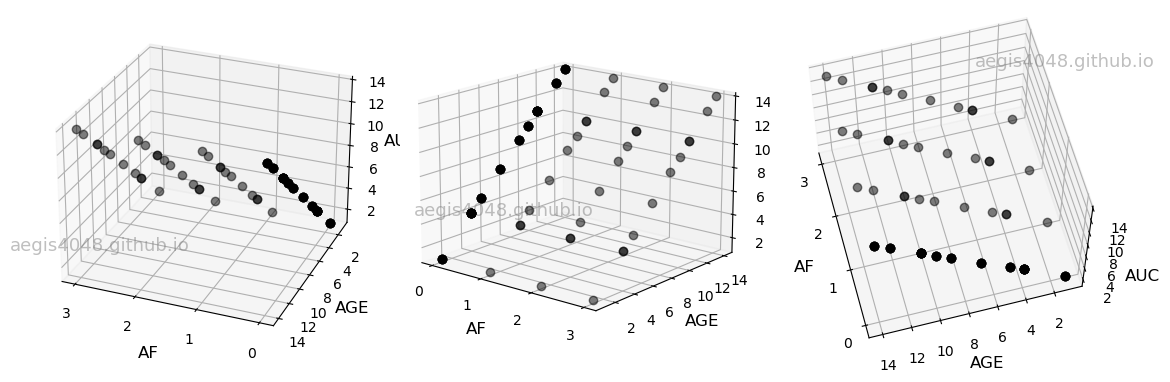

In [29]:
X = df[['AF_ordinal', 'AGE']].values.reshape(-1,2)
y = y

x = X[:,0]
y = X[:,1]
z = y


plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    #ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('AF', fontsize=12)
    ax.set_ylabel('AGE', fontsize=12)
    ax.set_zlabel('AUC', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=27, azim=112)
ax2.view_init(elev=16, azim=-51)
ax3.view_init(elev=60, azim=165)

fig.tight_layout()

In [30]:
from scipy import stats
mu, std = stats.norm.fit(result.resid)
mu, std

(-3.9009199910693e-16, 0.11809870247829694)

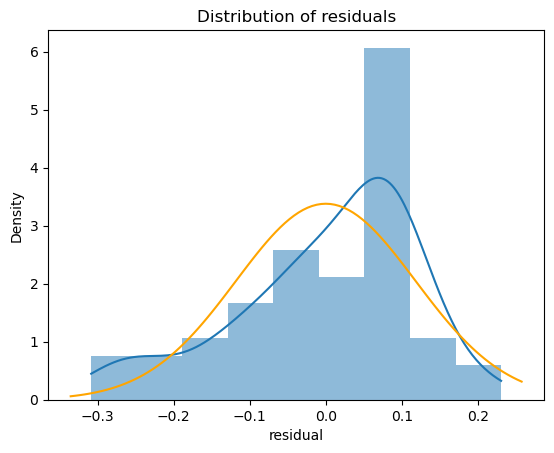

In [31]:
fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=result.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

In [32]:
SSR = sum(result.resid)
SSR

-4.29101199017623e-14

In [33]:
formula = 'Y = ' + str(round(reg.intercept_[0],4)) 
for i in range(len(reg.coef_[0])):
    formula += ' + ' + str(round(reg.coef_[0][i],4)) + '*' + labels[i] 
formula += ' + ' + str(round(SSR,4))

print("Linear regression model is:")
print(formula)

Linear regression model is:
Y = 0.8869 + -0.0076*AGE + -0.0445*PI_SEG + 0.0011*PIL + 0.0342*SEX_label + 0.018*AF_ordinal + -0.0


In [47]:
result.pvalues

const    1.135060e-26
x1       1.763432e-02
x2       2.168805e-11
x3       4.426424e-01
x4       4.622422e-01
x5       1.695433e-01
dtype: float64

In [49]:
pvalues = [p for p in result.pvalues]
pvalues

[1.1350597653170517e-26,
 0.017634321627420554,
 2.1688047223633134e-11,
 0.44264240089097906,
 0.4622422222139916,
 0.1695433466921174]

In [50]:
labels

['AGE', 'PI_SEG', 'PIL', 'SEX_label', 'AF_ordinal']

In [51]:
lbld_pvalues = [*zip(labels, pvalues[1:])]

In [52]:
# pvalues

lbld_pvalues.sort(key=lambda x:x[1])
lbld_pvalues

[('PI_SEG', 2.1688047223633134e-11),
 ('AGE', 0.017634321627420554),
 ('AF_ordinal', 0.1695433466921174),
 ('PIL', 0.44264240089097906),
 ('SEX_label', 0.4622422222139916)]

In [57]:
print('Most are greater than 0.1, therefore ignored. \nOnly PI_SEG and AGE is less than 0.05, therefore stat.sig.')

Most are greater than 0.1, therefore ignored. 
Only PI_SEG and AGE is less than 0.05, therefore stat.sig.
